# AGH Modelling of Physical Systems Lab 3 (2025 March 18th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl)

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$. 

Let's depict the problem using NumPy and matplotlib:

In [127]:
import numpy as np
from matplotlib import pyplot
from pint import Unit
import pint
from matplotlib import pyplot as plt
from open_atmos_jupyter_utils import show_plot

si = pint.UnitRegistry()

In [128]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

In [129]:
psi_0 = Psi_0()
nx = 64 # number of discretization points
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True) # coordinate grid
u = 2 # delta
t_max = 50 # max time

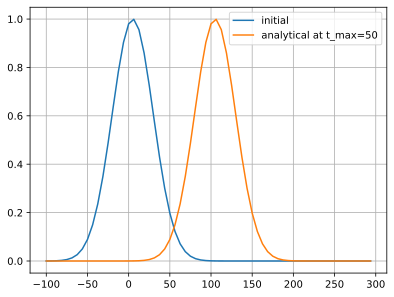

In [130]:
pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid momentum)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver: 

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [ ]:
class One:  # no inheritance of built-in types in Python
    def __radd__(self, other) -> slice:
        return slice(other.start + 1, other.stop + 1)

    def __rsub__(self, other) -> slice:
        return slice(other.start - 1, other.stop - 1)
    
def F(left, right, courant_number):
    return (
        .5 * (courant_number + abs(courant_number)) * left
        + .5 * (courant_number - abs(courant_number)) * right
    )

**5. upwind algorithm coded in Python/NumPy: data/objects**

In [ ]:
psi = psi_0(x)

nt: int = 16
dt: float = t_max / nt
C: np.float64 = u * dt / dx

one = One()
psi_slice_center = slice(1, nx - 2)  # (::)

**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

In [ ]:
# time-stepping
for _ in range(nt):
    psi[psi_slice_center] = psi[psi_slice_center] - (F(psi[psi_slice_center], psi[psi_slice_center + one], C) - F(psi[psi_slice_center - one], psi[psi_slice_center], C))

**7. comparing analytic and numerical solutions**

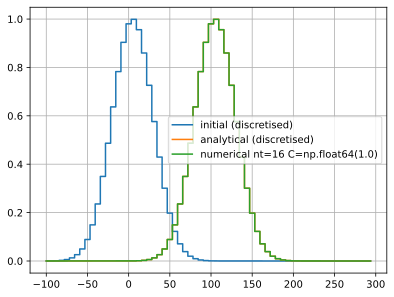

In [135]:
pyplot.step(x, psi_0(x), label='initial (discretised)', where='mid')
pyplot.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
pyplot.step(x, psi, label=f'numerical {nt=} {C=}', where='mid')
pyplot.legend()
pyplot.grid()
show_plot()

## Convergence analysis compares how a measure of error (here could be RMSE vs. analytic solution) changes with changing dt (temporal step, convergence in time) or dx (spatial convergence, convergence in space).

In [ ]:
def advection(x: np.ndarray, u: float, c_const: float, dx: float) -> np.ndarray:
    psi = psi_0(x)
    dt = c_const * dx / u
    nt = int(t_max / dt)
    psi_slice_center = slice(1, nx - 2)

    for _ in range(nt):
        psi[psi_slice_center] = (
            psi[psi_slice_center]
            - (F(psi[psi_slice_center], psi[psi_slice_center + one], c_const)
               - F(psi[psi_slice_center - one], psi[psi_slice_center], c_const))
        )
    return psi

In [ ]:
def rmse(predictions: np.ndarray, targets: np.ndarray) -> float:
    return np.sqrt(np.mean((predictions - targets) ** 2))

In [ ]:
def get_errors(x: np.ndarray, u: float, c_const: float, dx: np.ndarray) -> np.ndarray:
    errors = np.zeros(len(dx))
    for idx, dx_val in enumerate(dx):
        psi = advection(x, u, c_const, dx_val)
        analytical_solution = psi_0(x - u * t_max)
        errors[idx] = rmse(psi, analytical_solution)

    return errors


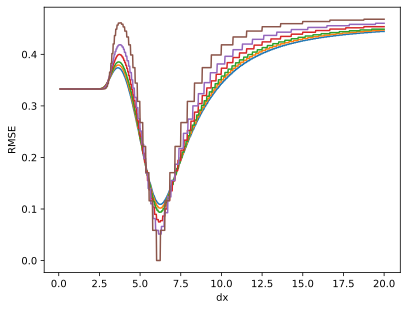

In [ ]:
dx_linspace = np.linspace(0.1, 20, 1000)
u = 3

for const in [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]:
    errors = get_errors(x, u, const, dx_linspace)
    plt.plot(dx_linspace, errors, label=f'c_const={const}')
    plt.xlabel('dx')
    plt.ylabel('RMSE')
show_plot()